## Data Structures and Data Types

- Resumen
    - Este cuaderno introduce Polars (implementación sobre Arrow) y explica cómo maneja estructuras y tipos de datos para análisis eficientes en memoria. Incluye explicación teórica, ejemplos prácticos y visualizaciones con Plotnine.

- Objetivos
    - Entender las estructuras de datos principales de Polars: Series, DataFrame y LazyFrame.
    - Conocer los tipos de datos soportados (numéricos, cadenas, booleanos, fechas, tipos categóricos, listas, structs).
    - Aprender operaciones comunes: selección, filtrado, agregación, joins y transformaciones perezosas (lazy).
    - Crear visualizaciones reproducibles usando Plotnine.
    - Mostrar buenas prácticas para trabajar con datos grandes y conservar reproducibilidad.

- Estructura del cuaderno
    1. Introducción: motivación y conceptos clave (Arrow, in-memory, rendimiento).
    2. Estructuras de datos en Polars: Series, DataFrame, LazyFrame — ejemplos básicos.
    3. Tipos de datos: descripción y casos especiales (nulls, categorical, datetime, listas, structs).
    4. Operaciones y transformaciones: selección, expresiones, groupby, joins y manejo de esquemas.
    5. Lazy execution: cuándo y por qué usar LazyFrame; optimizaciones y plan de ejecución.
    6. I/O: leer/escribir CSV, Parquet (nota: los archivos de datos no están incluidos en el repositorio).
    7. Visualización: ejemplos con Plotnine integrados a Polars.
    8. Ejemplos reproducibles y ejercicios prácticos.



### Series, DataFrames, and LazyFrames



In [1]:
import polars as pl

sales_series = pl.Series("sales", [150.00, 300.00, 250.00])
sales_series

sales
f64
150.0
300.0
250.0


In [2]:
# Implementación de dataframe en polars

sales_df = pl.DataFrame(
    {
       "sales": sales_series,
       "customer_id" : [24, 25, 26] 
    }
)
sales_df

sales,customer_id
f64,i64
150.0,24
300.0,25
250.0,26


### ¿Qué es un LazyFrame en Polars?

Un LazyFrame es la representación perezosa (deferred) de un DataFrame en Polars: en lugar de ejecutar las operaciones inmediatamente, se construye un plan lógico de consulta que se optimiza y ejecuta solo cuando se solicita el resultado (por ejemplo, con `collect()` o `fetch()`).

- Concepto clave
    - Las transformaciones (filter, select, with_columns, groupby, join, etc.) devuelven un LazyFrame y se encadenan sin computación inmediata.
    - La ejecución real ocurre al final: `collect()` (todo) o `fetch(n)` (muestras).

- Ventajas
    - Optimización del plan de ejecución (fusión de operaciones, eliminación de columnas innecesarias, pushdown de predicados).
    - Mejor uso de memoria y CPU en pipelines complejos o con datos grandes.
    - Permite reordenar/optimizar joins y agregaciones globalmente.

- Limitaciones
    - No puedes inspeccionar directamente los datos (shape, valores) sin materializar.
    - Algunas APIs/operaciones pueden requerir materializar resultados antes de usarlas.

- Métodos útiles
    - `lazy()` — convertir un DataFrame a LazyFrame.
    - `collect()` — ejecutar y devolver un DataFrame.
    - `fetch(n)` — ejecutar y devolver las primeras n filas.
    - `explain()` — mostrar el plan optimizado.
    - Operadores habituales: `select`, `filter`, `with_columns`, `groupby`, `join`, `sort`.



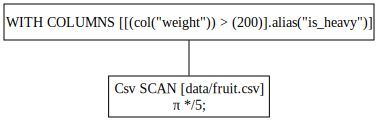

In [3]:
lazy_df = pl.scan_csv("data/fruit.csv").with_columns(
    is_heavy=pl.col("weight") > 200
)

lazy_df.show_graph()

In [4]:
lazy_df.collect()

name,weight,color,is_round,origin,is_heavy
str,i64,str,bool,str,bool
"""Avocado""",200,"""green""",false,"""South America""",false
"""Banana""",120,"""yellow""",false,"""Asia""",false
"""Blueberry""",1,"""blue""",false,"""North America""",false
"""Cantaloupe""",2500,"""orange""",true,"""Africa""",true
"""Cranberry""",2,"""red""",false,"""North America""",false
"""Elderberry""",1,"""black""",false,"""Europe""",false
"""Orange""",130,"""orange""",true,"""Asia""",false
"""Papaya""",1000,"""orange""",false,"""South America""",true
"""Peach""",150,"""orange""",true,"""Asia""",false


### Data Types

Resumen rápido: Polars ofrece tipos optimizados sobre Arrow para rendimiento en memoria. La siguiente tabla agrupa y describe los tipos más usados.

#### Numéricos
| Tipo | Detalles | Rango / notas |
|---|---:|---|
| `Float32` | 32-bit punto flotante | ~ -3.4e38 a 3.4e38 |
| `Float64` | 64-bit punto flotante | ~ -1.7e308 a 1.7e308 |
| `Decimal` | Decimal de 128-bit con precisión opcional y escala no negativa. | Representa exactamente hasta ~38 dígitos significativos |
| `Int8` | Entero con signo 8-bit | -128 a 127 |
| `Int16` | Entero con signo 16-bit | -32,768 a 32,767 |
| `Int32` | Entero con signo 32-bit | -2,147,483,648 a 2,147,483,647 |
| `Int64` | Entero con signo 64-bit | -9,223,372,036,854,775,808 a 9,223,372,036,854,775,807 |
| `UInt8` | Entero sin signo 8-bit | 0 a 255 |
| `UInt16` | Entero sin signo 16-bit | 0 a 65,535 |
| `UInt32` | Entero sin signo 32-bit | 0 a 4,294,967,295 |
| `UInt64` | Entero sin signo 64-bit | 0 a 18,446,744,073,709,551,615 (~1.84e19) |

#### Temporales
| Tipo | Detalles |
|---|---:|
| `Date` | Fecha calendario (Arrow `date32` — días desde 1970-01-01) |
| `Datetime` | Marca de tiempo exacta (int64 desde epoch). Unidad por defecto: microsegundos |
| `Duration` | Duración / delta de tiempo |
| `Time` | Hora del día |

#### Anidados / Colecciones
| Tipo | Detalles |
|---|---:|
| `Array` | Listas de longitud fija |
| `List` | Listas de longitud variable |
| `Struct` | Tipo estructurado (varias columnas como campo compuesto) |

#### Texto y categorías
| Tipo | Detalles |
|---|---:|
| `String` | UTF‑8, longitud variable |
| `Categorical` | Codificación categórica eficiente para pocas categorías únicas |
| `Enum` | Categórico fijo; las categorías deben definirse de antemano |

#### Otros
| Tipo | Detalles |
|---|---:|
| `Boolean` | `True` / `False` (almacenamiento muy compacto, bit-packed) |
| `Binary` | Bytes de longitud variable |
| `Null` | Representa valores nulos (`None`) |
| `Object` | Envuelve objetos arbitrarios de Python |
| `Unknown` | Placeholder interno — no usar en código de usuario |

Notas adicionales:
- La clase base para todos los tipos es la abstracción de tipos de Polars/Arrow.
- Polars puede desviarse de la especificación de Arrow en algunos detalles (p. ej. implementación propia de `String` para optimizaciones). Ver la documentación de Arrow para diferencias: https://arrow.apache.org/docs/python/api/datatypes.html.


### Tipos anidados en Polars: Array, List y Struct — Resumen

- **Array**
    - Colección de elementos del mismo tipo y forma fija por elemento de la Serie.
    - Útil para almacenamiento compacto y acceso indexado predecible.
    - Ejemplo conceptual: una `Series` donde cada fila contiene un arreglo de forma (3,).

- **List**
    - Colecciones de longitud variable por fila; cada elemento puede tener distinta longitud.
    - Flexible para datos jerárquicos o cuando las sub-series no tienen tamaño fijo.
    - Ejemplo conceptual: una columna donde cada fila es una lista de valores de distinto largo.

- **Struct**
    - Encapsula múltiples campos nombrados en un solo valor por fila (como un registro/objeto).
    - Útil para agrupar columnas relacionadas y acceder a subcampos por nombre.
    - Ejemplo conceptual: una columna `address` con subcampos `street`, `city`, `zip`.

Notas rápidas:
- `Array` exige homogeneidad de tipo y forma; `List` permite variabilidad en longitud; `Struct` agrupa campos heterogéneos por nombre.
- Elegir `Array` cuando la forma es fija y se busca eficiencia; `List` para variabilidad; `Struct` para modelar registros compuestos.

In [7]:
coordinates = pl.DataFrame(
    [
        pl.Series("pint_2d", [[1, 3], [2, 5]]),
        pl.Series("pint_3d", [[1, 7, 3], [8, 1, 0]]),
    ],
    schema={
        "pint_2d": pl.Array(shape=2, inner=pl.Int64),
        "pint_3d": pl.Array(shape=3, inner=pl.Int64)
    }
)
coordinates

pint_2d,pint_3d
"array[i64, 2]","array[i64, 3]"
"[1, 3]","[1, 7, 3]"
"[2, 5]","[8, 1, 0]"


In [8]:
weather_readings = pl.DataFrame(
    {
        "temperature" : [[72.5, 75.0, 77.3], [68.0, 70.2]],
        "wind_speed" : [[15, 20], [10, 12, 14, 16]]
    }
)

weather_readings

temperature,wind_speed
list[f64],list[i64]
"[72.5, 75.0, 77.3]","[15, 20]"
"[68.0, 70.2]","[10, 12, … 16]"


In [10]:
# The Struct

rating_series = pl.Series(
    "ratings",
    [
        {"Movie": "Cars", "Theater": "NE", "Avg_Rating": 4.5},
        {"Movie": "Toy Story", "Theater": "ME", "Avg_Rating": 4.9},
    ]
)

print(rating_series)

shape: (2,)
Series: 'ratings' [struct[3]]
[
	{"Cars","NE",4.5}
	{"Toy Story","ME",4.9}
]


## Missing Values

In [ ]:
missing_df = pl.DataFrame(
    {
        "value": [None, 2, 3, 4, None, None, 7, 8, 9, None]
    }
)

missing_df

value
i64
null
2
3
4
null
null
7
8
9


### NaN vs valores nulos en Polars — Resumen

- NaN representa “not a number” y sólo aplica a tipos float; no se considera valor faltante (null).
- Funciones que manejan nulos (p. ej. `df.null_count()` o `Expr.fill_null()`) no consideran NaN.
- Para detectar o rellenar NaN use `Expr.is_nan()` y `Expr.fill_nan()`.
- Use `fill_null()` para nulls y `fill_nan()` para NaN; trate ambos explícitamente si quiere normalizar ambos tipos de ausencia.

In [26]:
missing_df.with_columns(filled_with_single=pl.col("value").fill_null(-1))

value,filled_with_single
i64,i64
null,-1
2,2
3,3
4,4
null,-1
null,-1
7,7
8,8
9,9


In [20]:
print(
    missing_df.with_columns(
        forward=pl.col("value").fill_null(strategy="forward"),
        backward=pl.col("value").fill_null(strategy="backward"),
        min=pl.col("value").fill_null(strategy="min"),
        max=pl.col("value").fill_null(strategy="max"),
        mean=pl.col("value").fill_null(strategy="mean"),
        zero=pl.col("value").fill_null(strategy="zero"),
        one=pl.col("value").fill_null(strategy="one")
    )
)

shape: (10, 8)
┌───────┬─────────┬──────────┬─────┬─────┬──────┬──────┬─────┐
│ value ┆ forward ┆ backward ┆ min ┆ max ┆ mean ┆ zero ┆ one │
│ ---   ┆ ---     ┆ ---      ┆ --- ┆ --- ┆ ---  ┆ ---  ┆ --- │
│ i64   ┆ i64     ┆ i64      ┆ i64 ┆ i64 ┆ i64  ┆ i64  ┆ i64 │
╞═══════╪═════════╪══════════╪═════╪═════╪══════╪══════╪═════╡
│ null  ┆ null    ┆ 2        ┆ 2   ┆ 9   ┆ 5    ┆ 0    ┆ 1   │
│ 2     ┆ 2       ┆ 2        ┆ 2   ┆ 2   ┆ 2    ┆ 2    ┆ 2   │
│ 3     ┆ 3       ┆ 3        ┆ 3   ┆ 3   ┆ 3    ┆ 3    ┆ 3   │
│ 4     ┆ 4       ┆ 4        ┆ 4   ┆ 4   ┆ 4    ┆ 4    ┆ 4   │
│ null  ┆ 4       ┆ 7        ┆ 2   ┆ 9   ┆ 5    ┆ 0    ┆ 1   │
│ null  ┆ 4       ┆ 7        ┆ 2   ┆ 9   ┆ 5    ┆ 0    ┆ 1   │
│ 7     ┆ 7       ┆ 7        ┆ 7   ┆ 7   ┆ 7    ┆ 7    ┆ 7   │
│ 8     ┆ 8       ┆ 8        ┆ 8   ┆ 8   ┆ 8    ┆ 8    ┆ 8   │
│ 9     ┆ 9       ┆ 9        ┆ 9   ┆ 9   ┆ 9    ┆ 9    ┆ 9   │
│ null  ┆ 9       ┆ null     ┆ 2   ┆ 9   ┆ 5    ┆ 0    ┆ 1   │
└───────┴─────────┴──────────┴─────┴────

In [18]:
missing_df.with_columns(
    expression_mean=pl.col("value").fill_null(pl.col("value").mean())
)

value,expression_mean
i64,f64
null,5.5
2,2.0
3,3.0
4,4.0
null,5.5
null,5.5
7,7.0
8,8.0
9,9.0


In [19]:
missing_df.interpolate()

value
f64
null
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


### Data Type Conversión

In [ ]:
string_df = pl.DataFrame({"id": ["10000", "20000", "30000"]})
print(string_df)

# Check the estimated size of the DataFrame
print(f"Estimated size: {string_df.estimated_size('b')} bytes")

shape: (3, 1)
┌───────┐
│ id    │
│ ---   │
│ str   │
╞═══════╡
│ 10000 │
│ 20000 │
│ 30000 │
└───────┘
Estimated size: 15 bytes


In [25]:
int_df = string_df.select(pl.col("id").cast(pl.UInt16))
print(int_df)

# Check the estimated size of the DataFrame
print(f"Estimated size: {int_df.estimated_size('b')} bytes")

shape: (3, 1)
┌───────┐
│ id    │
│ ---   │
│ u16   │
╞═══════╡
│ 10000 │
│ 20000 │
│ 30000 │
└───────┘
Estimated size: 6 bytes


In [ ]:
# Create a DataFrame with different data types

data_types_df = pl.DataFrame(
    {
        "id": [10000, 20000, 30000],
        "value": [1.0, 2.0, 3.0],
        "value_2": ["1", "2", "3"],
    }
)

# Cast the DataFrame to a different data type
data_types_df.cast(pl.UInt16)

id,value,value_2
u16,u16,u16
10000,1,1
20000,2,2
30000,3,3


In [ ]:
data_types_df.cast(
    {
        "id": pl.UInt16,
        "value": pl.Float32,
        "value_2": pl.UInt8
    }
)

id,value,value_2
u16,f32,u8
10000,1.0,1
20000,2.0,2
30000,3.0,3
